### Let's load in all the results and transform them as necessary

In [2]:
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from dataclasses import dataclass

@dataclass
class AllSimulationResults:
    emotion_histories: list
    avg_emotions: list
    interventions: list
    G_networks: list
    DG_networks: list
    absorption_dicts: list
    initial_conditions: list
    sentiment_graphs: list
    intimacy_matrices: list

In [34]:
populationSize = 15
runs = 13
max_iterations = 260

# No internvention results
all_results_path_plain = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\No_Intervention\all_results.pkl"
heatmaps_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\No_Intervention\initial_conditions_heatmaps.pkl"

with open(all_results_path_plain, "rb") as f:
    all_results_wo = pickle.load(f)
with open(all_results_path_plain, "rb") as f:
    heatmaps_wo = pickle.load(f)


# High aperture results
all_results_path_high = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\High_Aperture\all_results.pkl"
heatmaps_path_high = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\High_Aperture\initial_conditions_heatmaps.pkl"

with open(all_results_path_high, "rb") as f:
    all_results_H = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_H = pickle.load(f)


# Low aperture results
all_results_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\Low_Aperture\all_results.pkl"
heatmaps_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_09_2025\Low_Aperture\initial_conditions_heatmaps.pkl"
with open(all_results_path_low, "rb") as f:
    all_results_L = pickle.load(f)
with open(all_results_path_low, "rb") as f:
    heatmaps_L = pickle.load(f)

In [35]:
def create_intervention_matrix(all_results):
    '''
    Create a Boolean matrix saying during which timesteps did the leader intervened (0=no, 1=yes) for all simulation runs
    '''
    all_interventions = all_results.interventions
    interventions_summary_df = pd.DataFrame({
        "Run": list(range(1, runs + 1)),
        "Intervention_Timesteps": [','.join(map(str, run)) for run in all_interventions],
        "Num_Interventions": [len(run) for run in all_interventions]
    })

    binary_matrix = np.zeros((runs, max_iterations+1), dtype=int)  # time 0 to 259 for 260 timesteps
    for i, run in enumerate(all_interventions):
        for t in run:
            binary_matrix[i, t] = 1

    interventions_bool_df = pd.DataFrame(binary_matrix).T  # shape: (max_iterations, runs)
    
    return interventions_bool_df, interventions_summary_df

interventions_bool_H, interventions_summary_H = create_intervention_matrix(all_results_H)
interventions_bool_L, interventions_summary_L = create_intervention_matrix(all_results_L)

In [36]:
def create_avg_emotions_matrix(all_results):
    '''
    Convert avg_emotions into a dataframe
    '''
    data = all_results.avg_emotions  # list of lists, one per run
    df_avg_emotions = pd.DataFrame(data).T  # transpose so rows = timesteps, cols = runs
    df_avg_emotions.columns = [f"Run_{i}" for i in range(len(data))]
    df_avg_emotions.insert(0, "Time", df_avg_emotions.index)
    #df_avg_emotions.reset_index(drop=True, inplace=True)
    return df_avg_emotions

dfWithout = create_avg_emotions_matrix(all_results_wo)
dfHigh = create_avg_emotions_matrix(all_results_H)
dfLow = create_avg_emotions_matrix(all_results_L)

In [37]:
# Are High and Low aperture different?
same_matrix = np.array_equal(interventions_bool_H, interventions_bool_L)
print("Boolean intervention matrices identical:", same_matrix)

Boolean intervention matrices identical: False


compare final emotion avg

# Statistical Analysis and Structural Analysis

## Statistics Time!
Remember, our focus is primarily on the dynamics of agent interactions, and how leadership influences those dynamics. We will give a brief explaination of the characteristics to help contextualize the simulation results, but that was what Bosse et al. worked on, so it will not be given as much attention here.

In [38]:
def summarize_interventions(interventions_bool, style_name):
    """
    Summarize the number of interventions per simulation run.
    
    Parameters:
    - interventions_bool: 2D numpy array (timesteps x runs) of 0/1
    - style_name: string label for style
    
    Returns:
    - pandas DataFrame with summary stats
    """
    # Sum interventions per run (column-wise)
    interventions_per_run = interventions_bool.sum(axis=0)
    
    # Minimum excluding 0
    nonzero_min = interventions_per_run[interventions_per_run > 0].min() if np.any(interventions_per_run > 0) else 0
    
    summary_dict = {
        'Style': style_name,
        'Min Interventions (excl 0)': nonzero_min,
        'Max Interventions': interventions_per_run.max(),
        'Average Interventions': interventions_per_run.mean().round()
    }
    
    return pd.DataFrame([summary_dict])

# Example usage
summary_H = summarize_interventions(interventions_bool_H, "High Aperture")
summary_L = summarize_interventions(interventions_bool_L, "Low Aperture")

summary_interventions = pd.concat([summary_H, summary_L], ignore_index=True)
summary_interventions

,Style,Min Interventions (excl 0),Max Interventions,Average Interventions
0,High Aperture,8,252,122.0
1,Low Aperture,48,232,54.0


In [39]:
def runs_with_min_interventions(interventions_bool):
    """
    Returns the indices of runs that have the minimum number of interventions (excluding 0).
    
    Parameters:
    - interventions_bool: 2D numpy array (timesteps x runs)
    
    Returns:
    - list of run indices (0-indexed)
    """
    # Sum interventions per run
    interventions_per_run = interventions_bool.sum(axis=0)
    
    # Find minimum excluding 0
    nonzero_min = interventions_per_run[interventions_per_run > 0].min()
    
    # Find runs that match that min
    runs_indices = np.where(interventions_per_run == nonzero_min)[0]
    
    return runs_indices.tolist()

# Example usage
runs_H = runs_with_min_interventions(interventions_bool_H)
runs_L = runs_with_min_interventions(interventions_bool_L)

print("High Aperture: runs with min interventions (excl 0) =", runs_H)
print("Low Aperture: runs with min interventions (excl 0) =", runs_L)


High Aperture: runs with min interventions (excl 0) = [5]
Low Aperture: runs with min interventions (excl 0) = [7]


What is it: A brief summary of differences between H vs L | I just wanted to see which simulations corresponded to the minimum intervention out of curiosity

Purpose: To very briefly (superficially?) highlight (or introduce?) the differences between H and L | I want to compare those simulations between the two (for my own curiosity)

Interpretation: The H leader intervenes more on average, though it seems a little interesting that, of all the simulations in which the leaders did intervene, the H leader had the lowest amount of interventions. If we wanted to hypothesize further, one might say this could suggest that early intervention could lead to fewer interventions, but that does not match the other simulation results as the high leader intervened more frequently on average. Therefore, I'd say further analysis on that specific simulation is required as I am wondering if the network structure of that specific simulation may have played a role as to why the H leader did not need to intervene so much. The L leader did not even intervene at all during there time in simulation 5 (avg emo did not meet their threshold during it). We could compare the network structures between the simulations as well and see what, if any, insights that reveals!

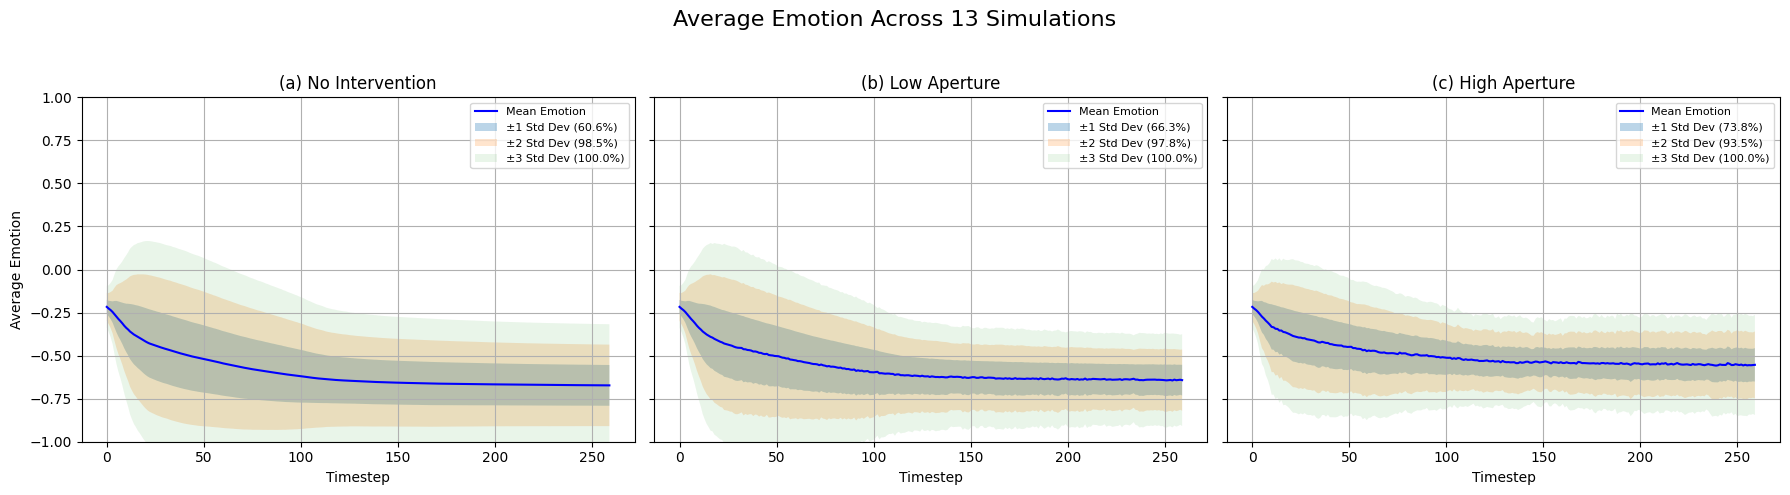

In [41]:
styles = ["(a) No Intervention", "(b) Low Aperture", "(c) High Aperture"]

def plot_all_styles_emotion(df_list, styles, runs, max_std=3):
    """
    Plot average emotion with ±1, ±2, ±3 std deviations for multiple styles in subplots.
    Also show percentage of points that lie within each band.
    
    df_list : list of DataFrames [dfWithout, dfHigh, dfLow]
    styles : list of strings ["No Intervention", "High Aperture", "Low Aperture"]
    """
    n_styles = len(df_list)
    fig, axes = plt.subplots(1, n_styles, figsize=(18, 5), sharey=True)

    alphas = [0.3, 0.2, 0.1]

    for ax, df, style in zip(axes, df_list, styles):
        values = df.iloc[:, 1:].to_numpy()   # shape (timesteps, runs)
        mean_emotion = values.mean(axis=1)
        std_emotion = values.std(axis=1)

        ax.plot(df.index, mean_emotion, label="Mean Emotion", color='blue')

        # calculate percentages within ±k std
        percentages = {}
        for k in range(1, max_std+1):
            # normalized z-scores
            z_scores = (values - mean_emotion[:, None]) / std_emotion[:, None]
            within = (abs(z_scores) <= k).mean() * 100  # percentage
            percentages[k] = within

            # shading
            ax.fill_between(df.index,
                            mean_emotion - k*std_emotion,
                            mean_emotion + k*std_emotion,
                            alpha=alphas[k-1],
                            label=f"±{k} Std Dev ({within:.1f}%)")

        ax.set_title(style)
        ax.set_xlabel("Timestep")
        ax.grid(True)
        if ax == axes[0]:
            ax.set_ylabel("Average Emotion")
        ax.set_ylim(-1, 1)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle(f"Average Emotion Across {runs} Simulations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_all_styles_emotion([dfWithout, dfLow, dfHigh], styles, runs)

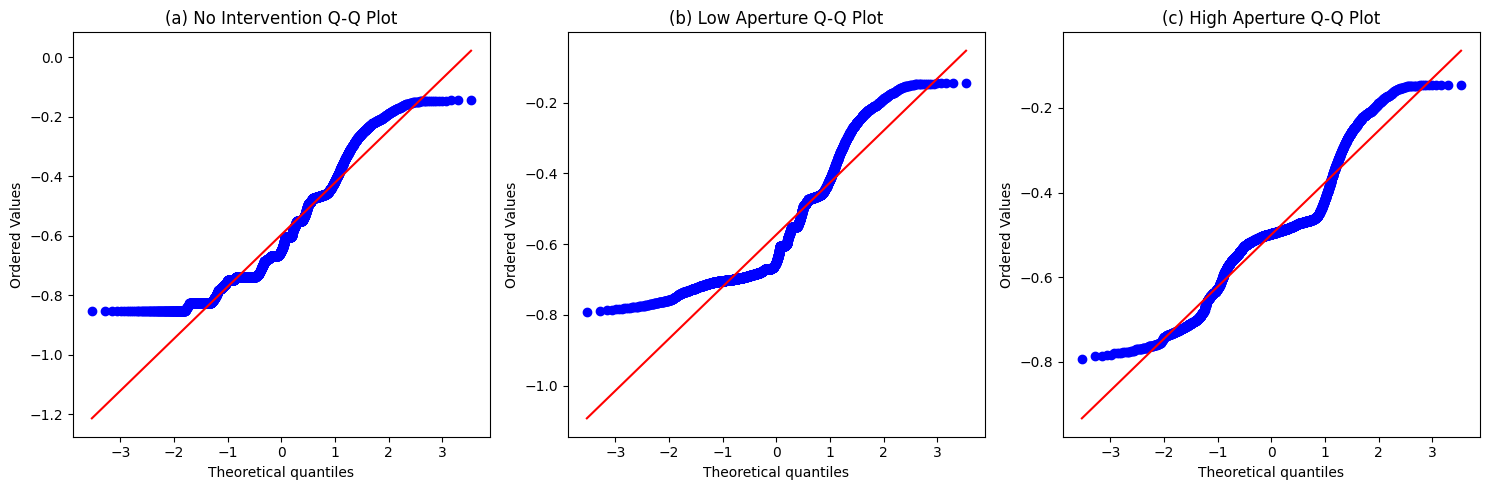

In [42]:
import scipy.stats as stats

df_list = [dfWithout, dfLow, dfHigh]

plt.figure(figsize=(15, 5))
for i, (df, style) in enumerate(zip(df_list, styles), 1):
    values = df.iloc[:, 1:].to_numpy().flatten()
    
    plt.subplot(1, 3, i)
    stats.probplot(values, dist="norm", plot=plt)
    plt.title(f"{style} Q-Q Plot")

plt.tight_layout()
plt.show()

The none matches better, but deviates at the ends. The Low is close around the middle, but has more deviates, especially at the ends. And the High is close at the beginning, but afterwards deviates increasingly.

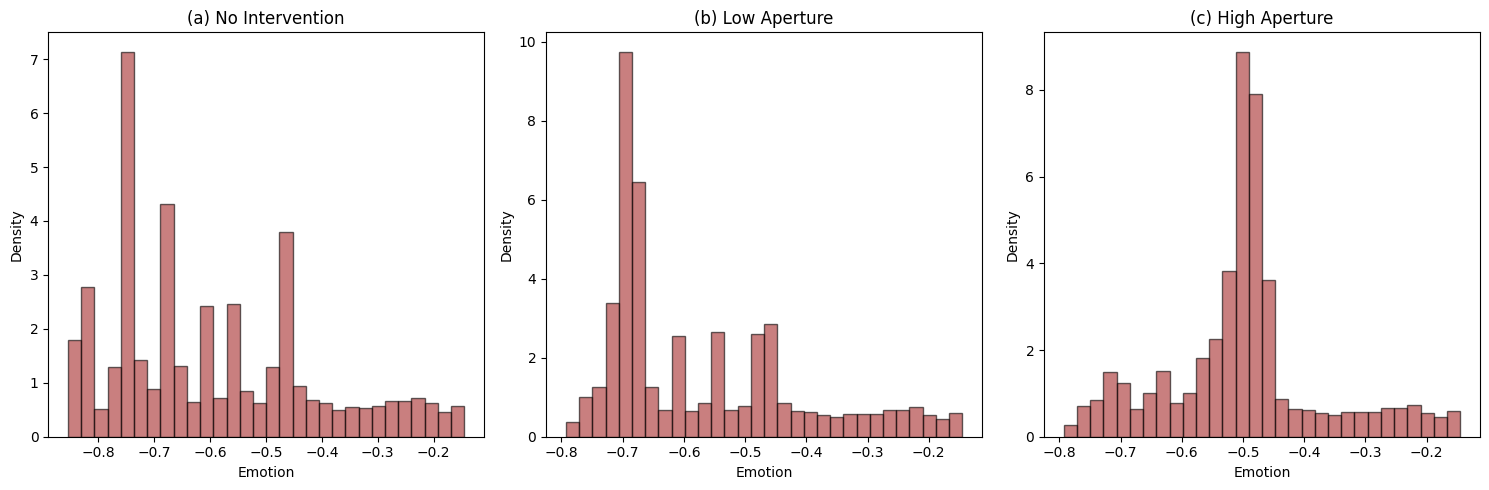

In [43]:
plt.figure(figsize=(15, 5))
for i, (df, style) in enumerate(zip(df_list, styles), 1):
    values = df.iloc[:, 1:].to_numpy().flatten()
    plt.subplot(1, 3, i)
    count, bins, ignored = plt.hist(values, bins=30, density=True, alpha=0.6, color='brown', edgecolor='black')
    
    plt.title(f"{style}")
    plt.xlabel("Emotion")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

The above are just the evolution of average emotions with shading indicating standard deviations from the average. The avg emo is not generally representative of individual emos, so we must keep this in mind during any test done using avg emos (unless we want to compare averages across leader types, then in that case maybe it is fine?).

In [44]:
from scipy.stats import ks_2samp, levene, linregress
from sklearn.metrics import auc

def analyze_leader_effects_from_dataclass(results_objects_dict):
    """
    results_objects_dict: dict with keys = style names, values = AllSimulationResults objects
                          e.g., {"No Intervention": all_results_wo_obj, "High Aperture": all_results_H_obj, ...}

    Returns a dictionary with KS, Levene, AUC, and slope results.
    """
    
    # Convert emotion_histories into long-form DataFrame
    records = []
    for style, sim_obj in results_objects_dict.items():
        emotion_histories = sim_obj.emotion_histories
        for run_idx, run in enumerate(emotion_histories):
            for t_idx, timestep in enumerate(run):
                for agent_idx, emotion in enumerate(timestep):
                    records.append({
                        "Run": run_idx,
                        "Timestep": t_idx,
                        "Agent": agent_idx,
                        "Emotion": emotion,
                        "Condition": style
                    })
    df = pd.DataFrame(records)

    # KS test at final timestep
    last_timestep = df['Timestep'].max()
    groups = df[df['Timestep'] == last_timestep].groupby('Condition')['Emotion'].apply(list)
    conditions = groups.index.tolist()
    ks_results = {}
    for i in range(len(conditions)):
        for j in range(i+1, len(conditions)):
            stat, p = ks_2samp(groups[conditions[i]], groups[conditions[j]])
            ks_results[f"{conditions[i]} vs {conditions[j]}"] = {"KS_stat": stat, "p_value": p}
    ks_df = pd.DataFrame(ks_results).T.round(4)

    # Levene's test (variance differences)
    stat, p = levene(*groups)
    levene_df = pd.DataFrame({"Levene_stat": [round(stat,4)], 
                              "p_value": [round(p,4)]})

    # AUC per condition
    auc_list = []
    for cond, group in df.groupby('Condition'):
        mean_curve = group.groupby('Timestep')['Emotion'].mean().sort_index()
        area = auc(mean_curve.index.values, mean_curve.values)
        auc_list.append({"Condition": cond, "AUC": round(area,4)})
    auc_df = pd.DataFrame(auc_list)

    # Slope per condition
    slopes_list = []
    for cond, group in df.groupby('Condition'):
        mean_curve = group.groupby('Timestep')['Emotion'].mean().sort_index()
        slope, intercept, r, p_val, stderr = linregress(mean_curve.index.values, mean_curve.values)
        slopes_list.append({
            "Condition": cond,
            "Slope": round(slope,4),
            "R2": round(r**2,4),
            "p_value": p_val  #round(p_val,4)
        })
    slopes_df = pd.DataFrame(slopes_list)

    return {
        "KS_test_final_timestep": ks_df,
        "Levene_test_final_timestep": levene_df,
        "AUC_results": auc_df,
        "Slopes_results": slopes_df
    }

results_objects_dict = {
    "No Intervention": all_results_wo,
    "High Aperture": all_results_H,
    "Low Aperture": all_results_L
}

results_summary = analyze_leader_effects_from_dataclass(results_objects_dict)
print("KS test (final timestep):\n", results_summary["KS_test_final_timestep"], "\n")
print("Levene's test (final timestep):\n", results_summary["Levene_test_final_timestep"], "\n")
print("AUC results:\n", results_summary["AUC_results"], "\n")
print("Slopes results:\n", results_summary["Slopes_results"], "\n")

KS test (final timestep):
                                   KS_stat  p_value
High Aperture vs Low Aperture      0.2308   0.0001
High Aperture vs No Intervention   0.2637   0.0000
Low Aperture vs No Intervention    0.1538   0.0268 

Levene's test (final timestep):
    Levene_stat  p_value
0       2.1429   0.1183 

AUC results:
          Condition       AUC
0    High Aperture -123.7189
1     Low Aperture -145.7797
2  No Intervention -154.6592 

Slopes results:
          Condition   Slope      R2       p_value
0    High Aperture -0.0007  0.6990  1.752757e-69
1     Low Aperture -0.0010  0.6761  2.366837e-65
2  No Intervention -0.0012  0.7017  5.591009e-70 



What is it: Some non-parametric (not using the average) statistical tests run using individual agent emotions.

- KS: compare distributions among pairs of leader styles (none/H, none/L, H/L) at the end of an evolution (simulation) in order to have an idea of whether we could say that those results came from the "same distribution" meaning whether we can statistically tell a difference when comparing the spread of emotions within those pairs. It tells us whether the emotional differences between agents across leader styles are significant.

- Levene: compare variances across groups (none/H/L) at the end of their evolutions in order to see how spread out the agents' emotions were within each group. Could signify if interventions led to increased emotional stability or not.

- AUC (area under curve): It's telling us how the evolution dynamics across groups were influenced by aperture type (so we can see how high vs low differed in the handling those emotion dynamics, even if a similar or same ending emotional ending was reached). Higher = agents were in higher emos.

- Slopes: This uses linear regression to fit a straight line onto the emotional trajectory for trend estimation (predictability) and tells if emos tended to inc, dec, or stay steady over time. The slope tells us the rate of change of the avg emo, r^2 tells us how well fitted the line is to the actual trajectory, and the p-val tells us how significant the difference of slope - 0 is.

Purpose: To compare the individual agent emotions not using the average to get a different angle on how their dynamics compare accross leadership style (none, low, high)

Interpretation: 

- KS (0,1): The KS values are all <0.3, so the difference between the distribution curves of each group are not very different, but since the p-values for none/H and H/L are both <0.01, the differences that are present may be statistically significant. The none/L p-value is <0.05 but >0.01 (and the KS is smallest at <0.2), so this suggests that even a low-aperture leader could induce some notable impact in the emotional states of their team members.

- Levene: the Levene statistic is ... and the p-value is 0.2288 so the differences in the spread of emotions among the groups seem to indeed be different (at least one group differs from the other two, specifically). From this, we can move on to analyze whether leader intervention increases/decreases emotional alignment among a team. (e.g. if we find that leader intervention dec emo alignment = inc variance = inc polarity :o)

- AUC: The AUC values are all negative which tells us the agents spent most of their time in the negative emotions (unsuprisingly, albeit disappointing). Though, the AUCs of each group are somewhat different with some none vs H being the most different, so this suggests to us that the emotional evolutions of the agents are different when there is intervention vs when there is not.

- Slopes: The slopes are all really small so there is not much great change in the average emotion over time. The R^2 is fairly high at around 0.6 for all three, but if it's using the average emo line, then we already know that's not very representative so I would hesitate to rely on this too much. And the p-values are incredibly small so it just tells us that the results are not just due to noise.

## Structure Time!

We've got two lists of graphs, so keep in mind that the analysis we do might have to be done over all of them

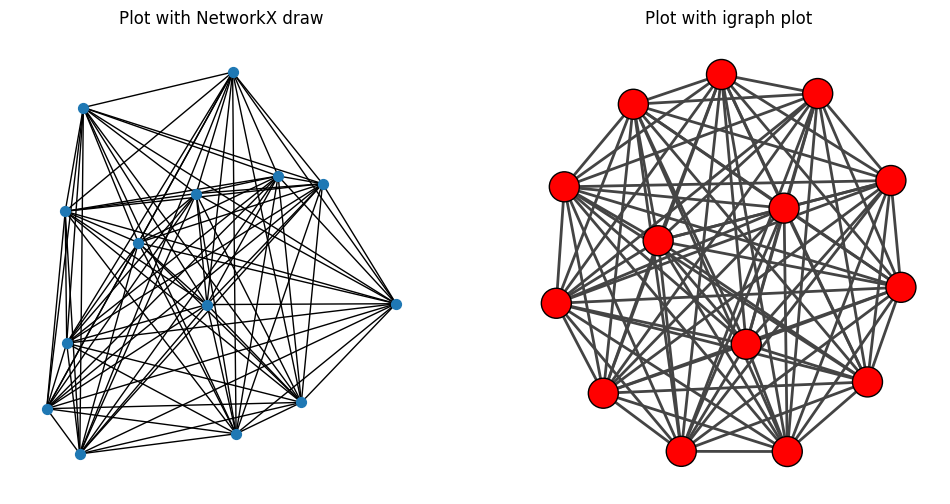

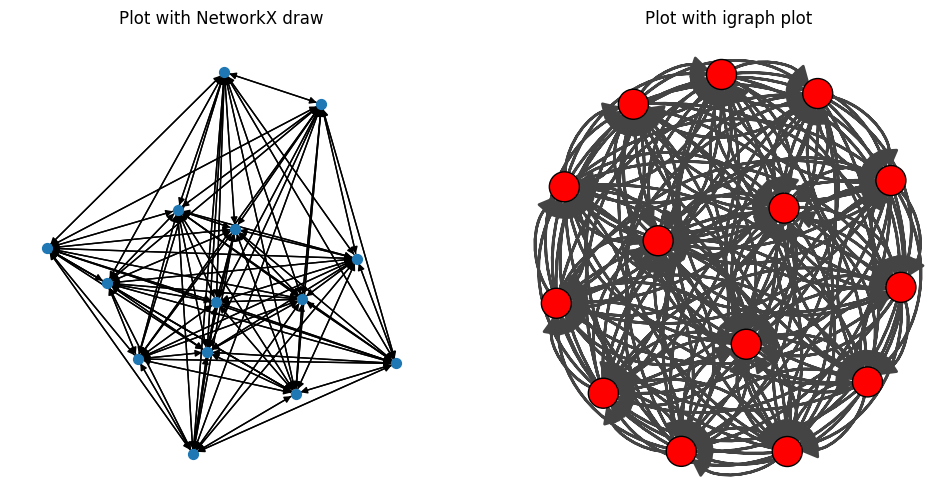

In [45]:
# sample visual
import igraph as ig
networkG = all_results_H.G_networks
networkDG = all_results_H.DG_networks

# convert to igraph
h = ig.Graph.from_networkx(networkG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax1)
plt.axis("off")
plt.show()


f = ig.Graph.from_networkx(networkDG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkDG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = f.layout_kamada_kawai()
ig.plot(f, layout=layout, target=ax1)
plt.axis("off")
plt.show()

Focus on edge weights and tools using edge weights

Possible hypotheses:
- Does network structure affect intervention influence?  
***Since only one structure has been used as of yet, bipartite community, this question should be revised if it's to be used in the current paper unless another structure is tested. Alternatively, we could compare tight-bipartite and loose-bipartite (referring to the intra and inter strengths used for the intimacy matrix generation) since that would be quickest to test and compare.***

- Compare starting network and ending network

In [46]:
# I don't like these variable names, but lets just continue
Gs_wo = all_results_wo.G_networks  # list of undirected newtworkx graphs, one per run (interaction frequencies)
Gs_H = all_results_H.G_networks
Gs_L = all_results_L.G_networks
Gs_styles = [Gs_wo, Gs_H, Gs_L]  # for iterating through each style when doing analysis -- list of lists

DGs_wo = all_results_wo.DG_networks  # list of directed newtworkx graphs, one per run (emotion absorption)
DGs_H = all_results_H.DG_networks
DGs_L = all_results_L.DG_networks
DGs_styles = [DGs_wo, DGs_H, DGs_L]

I_wo = all_results_wo.intimacy_matrices  # list of intimacy matrices, one per run
I_H = all_results_H.intimacy_matrices
I_L = all_results_L.intimacy_matrices
I_styles = [I_wo, I_H, I_L]

### Frobenius norm! 
We will take the G and DG graphs (yes, each of them) and convert them into a matrix representation. The structure of the networks aren't very complicated, so the matrices themselves should be straightforward to interpret. These matrices are called adjacency matrices. So, the G graphs adjacency matrices are symmetric and A[i,j] = A[j,i] (how many interactions they had), and the DG graphs are asymmetric in that A[i.j] is how much i influenced j and vice versa for A[j,i].

We start by creating one big average matrix per style (we average together all the adjacency matrices within each style), call this A_bar_i where i denotes the style type, and we use that as a potentially representative matrix for the general network structure of that style i. After that creation, we of course want to evaluate how representative it could actually be before using it, so we compare each adjacency matrix of style i to A_bar_i (all this is performed separately for the G/DG graphs, of course) to see how far each one is. We compute this distance using the Frobenium norm which allows us to compare matrix distances from each other! So, for each A_i., a small F_norm means its close to A_bar_i. This also tells us something, or gives us a look into, the consistency (stability?) of network structure across runs per style.

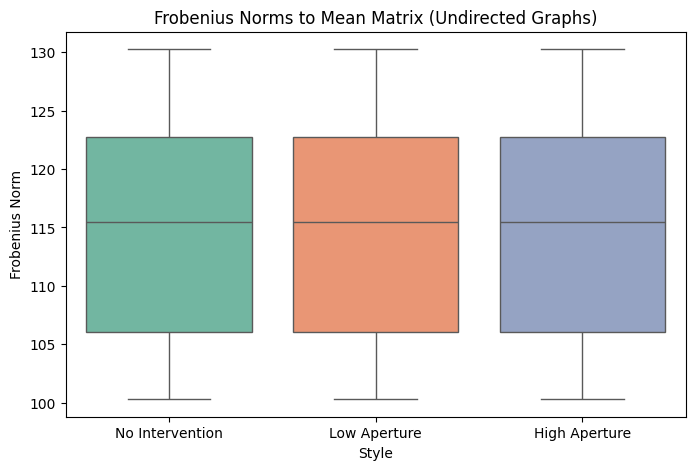

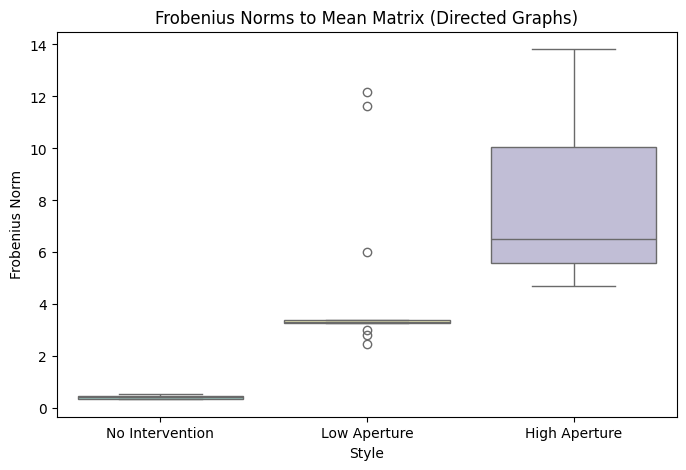

In [47]:
# Step 1) Convert each network to its adjacency matrix
def graph_to_adj_matrix(graphs_list):
    '''
    Convert a list of NetworkX graphs to their adjacency matrices.
    '''
    adj_matrices = []
    for G in graphs_list:
        A = nx.to_numpy_array(G, weight='weight', dtype=float)  # REMEMBER: for the DG graphs, A_ij = how much i influenced j (so instead of thinking 'how much did j get from i?', think 'how much did i give to j?')
        adj_matrices.append(A)

    return adj_matrices

# for each style of G and DG, apply the function
Gs_wo_adj = graph_to_adj_matrix(Gs_wo)  # list of adjacency matrices, one per run
Gs_H_adj = graph_to_adj_matrix(Gs_H)
Gs_L_adj = graph_to_adj_matrix(Gs_L)
Gs_styles_adj = [Gs_wo_adj, Gs_H_adj, Gs_L_adj]  # list of lists of adjacency matrices

DGs_wo_adj = graph_to_adj_matrix(DGs_wo)
DGs_H_adj = graph_to_adj_matrix(DGs_H)
DGs_L_adj = graph_to_adj_matrix(DGs_L)
DGs_styles_adj = [DGs_wo_adj, DGs_H_adj, DGs_L_adj]



# Step 2) Compute Frobenius norms between each pair of adjacency matrices within a style
def frobenius_norms_comparison(adj_list):
    '''
    We want to compare the adjacency matrices within a style to the mean matrix of that style to get an idea of how much they vary from each other, so we compute the Frobenius norm between each adjacency matrix and the mean matrix. 
    Smaller = more similar
    '''
    mean_matrix = np.mean(adj_list, axis=0)
    frobenius_norms = np.array([np.linalg.norm(A - mean_matrix, 'fro') for A in adj_list])
    return mean_matrix, frobenius_norms

# F norms for G and DG
mean_matrix_G_wo, fnorm_Gs_wo = frobenius_norms_comparison(Gs_wo_adj)
mean_matrix_G_H, fnorm_Gs_H = frobenius_norms_comparison(Gs_H_adj)
mean_matrix_G_L, fnorm_Gs_L = frobenius_norms_comparison(Gs_L_adj)

mean_matrix_DG_wo, fnorm_DGs_wo = frobenius_norms_comparison(DGs_wo_adj)
mean_matrix_DG_H, fnorm_DGs_H = frobenius_norms_comparison(DGs_H_adj)
mean_matrix_DG_L, fnorm_DGs_L = frobenius_norms_comparison(DGs_L_adj)



# Step 3) Visualize the Frobenius norms
styles = ['No Intervention', 'Low Aperture', 'High Aperture']
fnorm_data = {
    'style': [],
    'frobenius_norm': []
}

# Undirected graphs
for style_name, fnorms in zip(styles, [fnorm_Gs_wo, fnorm_Gs_L, fnorm_Gs_H]):
    fnorm_data['style'].extend([style_name]*len(fnorms))
    fnorm_data['frobenius_norm'].extend(fnorms)

df_fnorm = pd.DataFrame(fnorm_data)

plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm, palette='Set2', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Undirected Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()


# Directed graphs
fnorm_data_dir = {'style': [], 'frobenius_norm': []}
for style_name, fnorms in zip(styles, [fnorm_DGs_wo, fnorm_DGs_L, fnorm_DGs_H]):
    fnorm_data_dir['style'].extend([style_name]*len(fnorms))
    fnorm_data_dir['frobenius_norm'].extend(fnorms)

df_fnorm_dir = pd.DataFrame(fnorm_data_dir)

plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm_dir, palette='Set3', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Directed Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()

In [48]:
# Undirected Graphs
df_fnorm_G = pd.DataFrame({
    "No Intervention": fnorm_Gs_wo,
    "High Aperture": fnorm_Gs_H,
    "Low Aperture": fnorm_Gs_L
})
df_fnorm_G.index = [f"Run {i+1}" for i in range(len(df_fnorm_G))]

print("Frobenius Norms (Undirected Graphs):")
display(df_fnorm_G)


# Directed Graphs
df_fnorm_DG = pd.DataFrame({
    "No Intervention": fnorm_DGs_wo,
    "High Aperture": fnorm_DGs_H,
    "Low Aperture": fnorm_DGs_L
})
df_fnorm_DG.index = [f"Run {i+1}" for i in range(len(df_fnorm_DG))]

print("Frobenius Norms (Directed Graphs):")
display(df_fnorm_DG)

Frobenius Norms (Undirected Graphs):


,No Intervention,High Aperture,Low Aperture
Run 1,106.076114,106.076114,106.076114
Run 2,120.689636,120.689636,120.689636
Run 3,125.087614,125.087614,125.087614
Run 4,113.720929,113.720929,113.720929
Run 5,103.788930,103.788930,103.788930
Run 6,130.251191,130.251191,130.251191
Run 7,100.305628,100.305628,100.305628
Run 8,100.822710,100.822710,100.822710
Run 9,118.398885,118.398885,118.398885
Run 10,115.440243,115.440243,115.440243


Frobenius Norms (Directed Graphs):


,No Intervention,High Aperture,Low Aperture
Run 1,0.479086,11.194510,12.169204
Run 2,0.426726,5.574085,3.304793
Run 3,0.407463,6.429011,3.292179
Run 4,0.483530,6.566304,3.402444
Run 5,0.353155,5.450305,3.323803
Run 6,0.379896,6.228028,3.302981
Run 7,0.487199,6.937107,2.826084
Run 8,0.359032,4.704058,2.478461
Run 9,0.350712,4.977618,3.296286
Run 10,0.538989,13.478830,11.638906


The first one looking identical to each other makes sense because those matrices/graphs represent the interaction frequency, so style shouldn't affect this much at all (particularly because we are not doing any network interventions involving segmentation). 

The directed graphs are more interesting. It looks like No Intervention and Low keep quite consistent network structures across runs, with the exception of four outliers for Low. The error bars don't even reach out far. Then the High has a wider range, so perhaps the increased interventions disrupt the network structure in someway such that there is more variation, but there are no outliers here, so A_bar_H seems fine to go. As for those Low outliers, that would 4/13 outlier simulations which we could either keep or remove. I will just keep them, but we must keep those in mind during any further analysis with Low.

So, interactions are unaffected and consistent, but emotion flow is more sensitive to perturbations.

Overall, most are close enough to the mean, with the exception of four outliers for the DG graphs for Low. So, let us proceed with a coarse-grained analysis using the mean matrices for each style, and just keep in mind the those outliers during interpretation as I'm not sure what kind of impact they may have by being left in.

### Coarse-grained Analysis
We're using the mean matrices for the G-interaction and DG-absorption graphs. We can do a fine-grained analysis to focus more on the initial conditions of agent parameters, but for now our focus is on **leader intervention** and network structure (which we deliberately created).

In [49]:
# Are the mean matrices for the G and DG graphs the same for High and Low Aperture?
print(f"G's identical: {np.array_equal(mean_matrix_G_H, mean_matrix_G_L)}")  # the interaction frequencies are similar which does make sense
print(f"DG's identical: {np.array_equal(mean_matrix_DG_H, mean_matrix_DG_L)}")  # the emotion absorption are not similar so this is aligns with our expectations

G's identical: True
DG's identical: False


Yeah, this^ is fine. Interactions are the same regardless of leader aligns with our expectations given our rules/design of simulations, but emotion flow varies which is a relief.

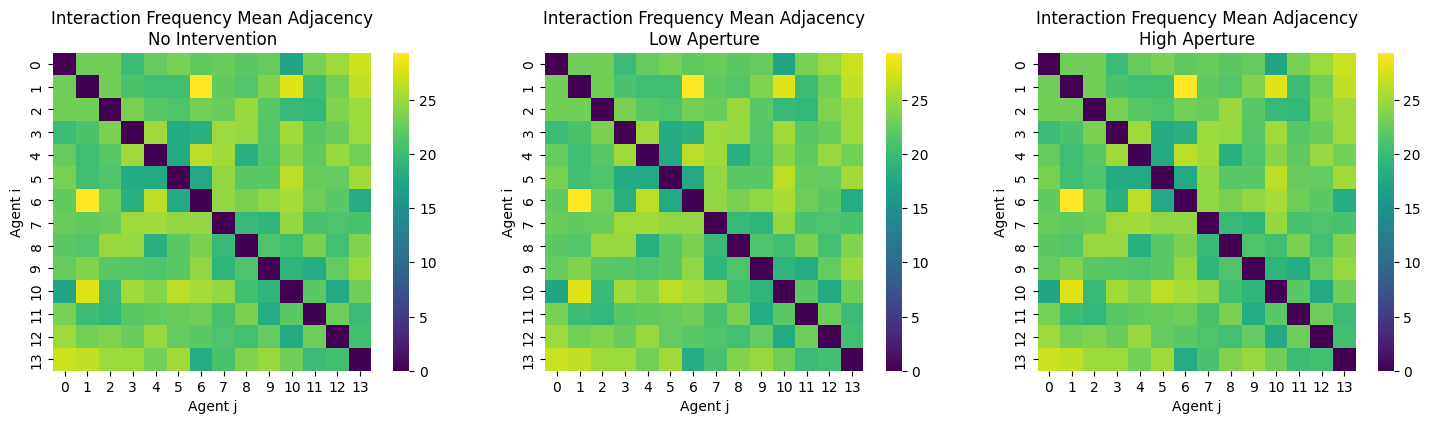

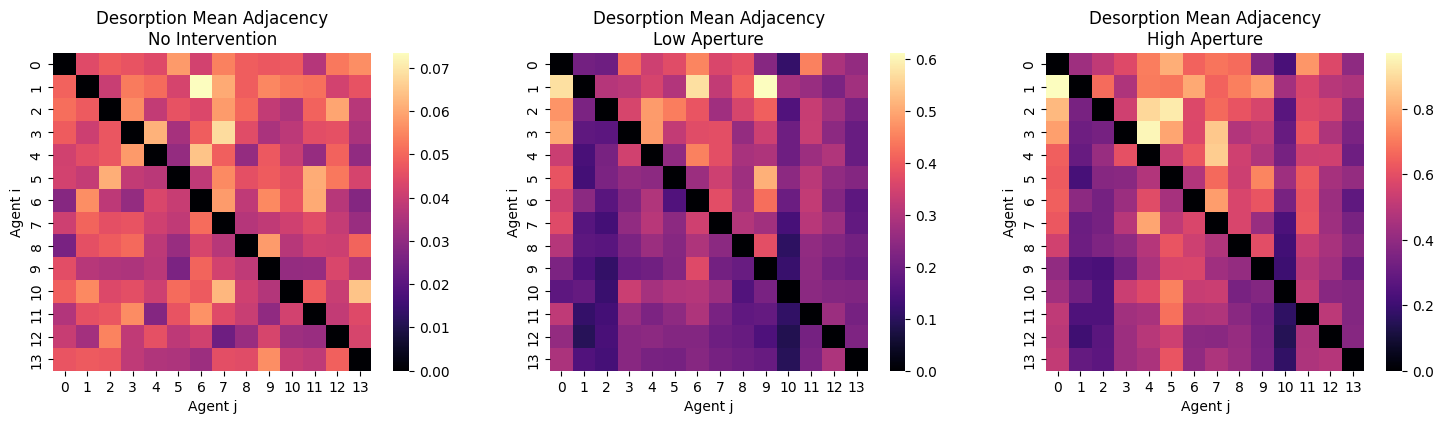

In [50]:
# Heatmaps to visualize the mean adjacency matrices for G and DG graphs
# Mean matrices you computed earlier
styles = ['No Intervention', 'Low Aperture', 'High Aperture'] 
mean_matrices_G = [mean_matrix_G_wo, mean_matrix_G_L, mean_matrix_G_H]
mean_matrices_DG = [mean_matrix_DG_wo, mean_matrix_DG_L, mean_matrix_DG_H]

# Plot G graphs (interaction frequencies)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_G)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='viridis', square=True)
    plt.title(f'Interaction Frequency Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()

# Plot DG graphs (emotion absorption)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_DG)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='magma', square=True)
    plt.title(f'Desorption Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()

Note how they all line up with our bipartite network structure from our intimacy matrix!

For the Interaction Frequency ones, it shows us the avg interaction weight between (i,j) across all runs (**symmetric**). More yellow = more frequent.

The Absorption ones show us the avg emotion desorption/emission/radiance (whats a good term/description??) from i to j (**asymmetric**). It might be easier to read it this way (left axis = sender, bottom axis = receiver)

Lighter = more was absorbed by j (so they are big receivers). We can look for giving/absorbing patterns among agents (this can be one way of identifying potentially influential agents). Let's see... (in our paper, we can describe a few specifics to help give readers understanding)

- For Low and High, agents 1,2,10 (maybe 13 slightly) are low receivers in within and outside of their community.

So, 

- Intervention has no affect on the interaction patterns amongst agents (as we saw in the first box-whisker plot).

- Intervention has some affect when it comes to the dynamics of emotional absorption though, so there is some interference there. This suggests that intervention interrupts (local patterns of?) emotional influence among agents! ... something something "the propagation of emotions"

In [51]:
# Clustering coefficient for community detection verification
def weighted_clustering_coefficient(adj_matrix, directed=False):
    """
    Compute the average weighted clustering coefficient for a graph represented by an adjacency matrix.

    Parameters:
    - adj_matrix: np.ndarray, adjacency matrix with weights
    - directed: bool, whether the graph is directed (will convert to undirected for clustering if True)

    Returns:
    - avg_clustering: float, average weighted clustering coefficient
    """
    if directed:
        # Convert directed to undirected for clustering purposes
        G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
        G_undirected = G.to_undirected()
    else:
        G_undirected = nx.from_numpy_array(adj_matrix)

    # Compute weighted clustering coefficient per node
    clustering_dict = nx.clustering(G_undirected, weight='weight')
    avg_clustering = np.mean(list(clustering_dict.values()))
    return avg_clustering


# Undirected graphs (interaction frequency)
avg_clust_G_wo = weighted_clustering_coefficient(mean_matrix_G_wo, directed=False)
avg_clust_G_L  = weighted_clustering_coefficient(mean_matrix_G_L, directed=False)
avg_clust_G_H  = weighted_clustering_coefficient(mean_matrix_G_H, directed=False)

# Directed graphs (emotion absorption)
avg_clust_DG_wo = weighted_clustering_coefficient(mean_matrix_DG_wo, directed=True)
avg_clust_DG_L  = weighted_clustering_coefficient(mean_matrix_DG_L, directed=True)
avg_clust_DG_H  = weighted_clustering_coefficient(mean_matrix_DG_H, directed=True)

print("                             No Intervention  Low Aperture        High Aperture")
print("Weighted clustering (G)  :", avg_clust_G_wo,  avg_clust_G_L, avg_clust_G_H)
print("Weighted clustering (DG) :", avg_clust_DG_wo, avg_clust_DG_L, avg_clust_DG_H)


                             No Intervention  Low Aperture        High Aperture
Weighted clustering (G)  : 0.7600001915160999 0.7600001915160999 0.7600001915160999
Weighted clustering (DG) : 0.6719628093159145 0.3890090544939621 0.4411378945015774


Verification that our created communities are somewhat detectable, though it's lower for the absorption graphs for both apertures, which could suggest that leader intervention could be interfering with the network structure of the team. From a theoretical perspective, how could we (as researchers/simulators) or a leader use this?

Should we look at the the edge weights in some sort of visual? Like see how they are distributed across all styles? This could be general (e.g. looking at the average weights), or it could be specific (e.g. looking at the exact weights per run, though this might not be as easy to look at...)